<a href="https://colab.research.google.com/github/lexxai/goit_python_ds_hw_09/blob/main/goit_python_ds_hw_09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Модуль 9. Підбір гіперпараметрів НМ

*З циклу [домашніх завдань Python Data Science](https://github.com/lexxai/goit_python_data_sciense_homework).*

# Домашнє завдання

## Про датасет Fashion-MNIST

Дану нейромережу ми будемо вивчати на датасеті Fashion-MNIST.
Fashion-MNIST - це набір даних зображень статей Zalando, що складається з навчального набору з 60 000 прикладів і тестового набору з 10 000 прикладів. Кожен приклад - це зображення 28x28 у відтінках сірого, пов'язане з міткою з 10 класів. Кожен піксель приймає значення від 0 до 255.

**Label	Description**

| Label | Clothing Item | --- | Label | Clothing Item | --- | Label | Clothing Item | --- | Label | Clothing Item | --- | Label | Clothing Item |
|-------|---------------|-----|-------|---------------|-----|-------|---------------|-----|-------|---------------|-----|-------|---------------|
| 0     | T-shirt/top   |     | 2     | Pullover      |     | 4     | Coat          |     | 6     | Shirt         |     | 8     | Bag           |
| 1     | Trouser       |     | 3     | Dress         |     | 5     | Sandal        |     | 7     | Sneaker       |     | 9     | Ankle boot    |





In [58]:
from pathlib import Path
import pickle
import tensorflow as tf

from keras.models import Sequential, load_model, save_model
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization

from keras import optimizers, regularizers
from keras import losses, metrics
from keras.utils import plot_model

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoLocator, FixedLocator
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score

## Завантажуємо датасет

In [2]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import fashion_mnist

# Завантажуємо датасет
(x_train_l, y_train_l), (x_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [3]:
num_classes = 10 # загальна кількість класів
batch_size = 512 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
learning_rate = 0.005 # швидкість навчання нейронної мережі
num_features = x_train_l.shape[1] * x_train_l.shape[2] # кількість атрибутів вхідного вектора 28 * 28 = 784
num_features
shuffle_bacth = True
ignore_saved_model = False
model_zip_url = "https://drive.usercontent.google.com/download?id=10IrPreMKLTAT7BKhK693X0X1JnvygJnQ&export=download&authuser=0&confirm=t&uuid=5a9a563d-2293-4cf5-93c6-01817bcc0b4a&at=APZUnTVbpcv754xLJV0UHjdopQ3T%3A1708957723379"
model_zip = Path("goit_python_ds_hw_09_models.zip")
gdrive = Path("/content/drive/")
model_zip_gdrive = gdrive.joinpath("MyDrive/Colab Notebooks/GoIT/datasets/").joinpath(model_zip)

### Спроба рівномірно перерозподілити данні щоб кожен блок мав однакову кількість класів

In [4]:
# @title
from sklearn.model_selection import StratifiedKFold


def split_data_equally_by_class(x, y, num_blocks):
    skf = StratifiedKFold(n_splits=num_blocks, shuffle=True, random_state=42)
    block_indices = []
    for _, block_index in skf.split(np.zeros(len(y)), y):
        block_indices.append(block_index)
    indices = np.concatenate(block_indices)
    #print(indices)
    return x[indices],y[indices]

def print_class_weights(y_train_blocks):
  batchs = y_train_blocks.shape[0] // batch_size
  print(f"{batchs=}, tolal_rows={batchs*batch_size}, {batch_size=}")
  print('#  [ uniq. class list  ] 1.0 [         count of classes div to block size                ]   std deviation')
  print("-"*110)
  for i in range(20):
    si = i*batch_size
    ei = (i+1)*batch_size
    block = y_train_blocks[si:ei]
    unique_classes, unique_classes_count = np.unique(block, return_counts=True)
    print(f"{i:2}", unique_classes, len(unique_classes)/num_classes, unique_classes_count/batch_size, np.std(unique_classes_count))

if not shuffle_bacth:
  print("before split_data_equally_by_class")
  print(x_train_l.shape)
  print(y_train_l.shape)
  print_class_weights(y_train_l)
  x_train, y_train = split_data_equally_by_class(x_train_l, y_train_l, num_blocks=batch_size)
else:
  x_train, y_train = x_train_l, y_train_l

if not shuffle_bacth:
  print("\nafter split_data_equally_by_class")
  print(x_train.shape)
  print(y_train.shape)
  print_class_weights(y_train)



In [5]:
labels = ['T-shirt/top', 'Trouser', "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
labels_uk = ["Футболка/топ", "Штани", "Пуловер", "Сукня", "Пальто", "Босоніжки", "Сорочка", "Кросівки", "Сумка", "Черевики"]

In [6]:
# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

In [7]:
x_train.shape[1:]

(28, 28)

## Створення моделей НМ

In [8]:
n_hidden_1 = 256 # кількість нейронів 1-го шару
n_hidden_2 = 512 # кількість нейронів 2-го шару
n_hidden_3 = 16 # кількість нейронів 3-го шару

models = {}
models_his = {}
results = {}

In [44]:
# LOAD, SAVE MODLELS AND HISTORY

def load_models_gdrive(model_zip):
  print(model_zip)
  if model_zip.exists():
      !unzip -o "$model_zip"

def load_models_url(zip_url, model_zip):
 if not model_zip.exists():
    !wget $zip_url -O $model_zip
    if model_zip.exists():
      !unzip -o $model_zip

def save_all():
  for name in models:
    print(f"Save {name}")
    savemodel(name, models[name], models_his[name])
  zip_files()

def zip_files():
  print("Creating {model_zip}")
  !zip $model_zip *.keras *.pikle

def savemodel(name, model, history):
  filepath=Path(f"{name}_model.keras")
  model.save(filepath)
  filepath=Path(f"{name}_history.pikle")
  with filepath.open('wb') as f:
      pickle.dump(history, f)

def loadmodel(name):
  if ignore_saved_model:
    return None
  filepath=Path(f"{name}_model.keras")
  if filepath.exists():
    models[name] = load_model(filepath)
    filepath=Path(f"{name}_history.pikle")
    if filepath.exists():
      with filepath.open('rb') as f:
        return pickle.load(f)

# Dynamic learn rate that depend of epoch
def scheduler(epoch, lr, thresh=7, thresh_lr=0.001):
  if epoch < thresh:
    return lr
  else:
    return thresh_lr
    # return lr * tf.math.exp(-0.1)

def scheduler_exp(epoch, lr, thresh=7):
  if epoch < thresh:
    return lr
  else:
    return lr * tf.math.exp(-0.1)


def get_callbacks(name, lr_sheduler=None):
    # Define early stopping callback
    early_stopping_acc = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                          patience=accurqcy_patience, verbose=1,
                                                          restore_best_weights=True)

    early_stopping_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                           patience=loss_patience, verbose=1,
                                                           restore_best_weights=True, start_from_epoch=4)


    # Define model checkpoint callback to save the best model
    model_checkpoint_acc = tf.keras.callbacks.ModelCheckpoint(filepath=f"{name}_best_model_acc.h5",
                                                           monitor='val_accuracy',
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           verbose=1)

    model_checkpoint_loss = tf.keras.callbacks.ModelCheckpoint(filepath=f"{name}_best_model_loss.h5",
                                                           monitor='val_loss',
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           verbose=1)

    if lr_sheduler is None:
      lr_sheduler = scheduler
    learing_rate = tf.keras.callbacks.LearningRateScheduler(lr_sheduler)


    return [early_stopping_loss, early_stopping_acc, model_checkpoint_acc, model_checkpoint_loss, learing_rate]


def compile_and_fit(model, name, batch_size=512, learning_rate=learning_rate, max_epochs=100, optimizer=None, shedule=None):
  if optimizer is None:
    optimizer = optimizers.Adam(learning_rate=learning_rate)
  model.compile(
      optimizer=optimizer,
      loss='sparse_categorical_crossentropy',
      metrics=["accuracy"]
  )
  model.summary()
  history = loadmodel(name)
  if history is None:
    history = model.fit(
        x_train,
        y_train,
        shuffle=shuffle_bacth,
        epochs=max_epochs,
        batch_size=batch_size,
        validation_data=(x_test, y_test),
        callbacks=get_callbacks(name, shedule),
        use_multiprocessing=True
    )
    savemodel(name, model, history)
  return history

In [10]:
# @title
from google.colab import drive

if not gdrive.exists():
  drive.mount(gdrive)

load_models_gdrive(model_zip_gdrive)

/content/drive/MyDrive/Colab Notebooks/GoIT/datasets/goit_python_ds_hw_09_models.zip
Archive:  /content/drive/MyDrive/Colab Notebooks/GoIT/datasets/goit_python_ds_hw_09_models.zip
  inflating: Model_2_lrelu_b32_model.keras  
  inflating: Model_2_lrelu_b32_history.pikle  
  inflating: Model_1_L2_0.025_model.keras  
  inflating: Model_1_L2_0.1_model.keras  
  inflating: Model_1_no_reg_model.keras  
  inflating: Model_2_L2_0.1_model.keras  
  inflating: Model_2_L2_1_model.keras  
  inflating: Model_2_lrelu_model.keras  
  inflating: Model_2_model.keras     
  inflating: Model_3_DO_0.2_model.keras  
  inflating: Model_3_DO_0.5_model.keras  
  inflating: Model_1_L2_0.025_history.pikle  
  inflating: Model_1_L2_0.1_history.pikle  
  inflating: Model_1_no_reg_history.pikle  
  inflating: Model_2_history.pikle   
  inflating: Model_2_L2_0.1_history.pikle  
  inflating: Model_2_L2_1_history.pikle  
  inflating: Model_2_lrelu_history.pikle  
  inflating: Model_3_DO_0.2_history.pikle  
  inflatin

## Додаємо першу модель НМ версія 1 (IL-HL1-HL2-HL3-HL4-OL) з регулярізацією L2 (0.025) в "HL2", ативаційна функція 'relu'

In [11]:
model_name = "Model_1_L2_0.025"

kernel_regularizer=regularizers.l2(0.025)

models[model_name] = Sequential([
    # Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)),
    # MaxPooling2D(2, 2),
    # Flatten(), leaky_relu
    Flatten(input_shape=x_train.shape[1:], name="INPUT"),
    Dense(n_hidden_1, activation='relu', name="Hidden_Layer_1"),
    # Dropout(0.5),
    Dense(n_hidden_2, activation='relu', kernel_regularizer=kernel_regularizer, name="Hidden_Layer_2"),
    Dense(256, activation='relu', name="Hidden_Layer_3"),
    Dense(32, activation='relu', name="Hidden_Layer_4"),
    # Dense(n_hidden_3, activation='relu', name="Hidden_Layer_3"),
    Dense(num_classes, activation='softmax', name="OUTPUT"),
],name=model_name)

# model.compile(
#     optimizer=optimizers.Adam(learning_rate=learning_rate),
#     loss='sparse_categorical_crossentropy',
#     metrics=["accuracy"]
# )

# model.summary()
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Навчання першої моделі НМ

In [12]:
epochs = 60
accurqcy_patience = 10
loss_patience = 5

models[model_name].reset_states()
models_his[model_name] = compile_and_fit(models[model_name], model_name, batch_size=batch_size, max_epochs=epochs)

Model: "Model_1_L2_0.025"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (Flatten)             (None, 784)               0         
                                                                 
 Hidden_Layer_1 (Dense)      (None, 256)               200960    
                                                                 
 Hidden_Layer_2 (Dense)      (None, 512)               131584    
                                                                 
 Hidden_Layer_3 (Dense)      (None, 256)               131328    
                                                                 
 Hidden_Layer_4 (Dense)      (None, 32)                8224      
                                                                 
 OUTPUT (Dense)              (None, 10)                330       
                                                                 
Total params: 472426 (1.80 MB)
Trainable params: 4

## Аналіз результатів першої моделі

In [13]:
results[model_name] = models[model_name].evaluate(x_test, y_test, verbose=True)
print(results[model_name])

313/313 [==============================] - 4s 11ms/step - loss: 0.3445 - accuracy: 0.8868
[0.344486266374588, 0.8867999911308289]


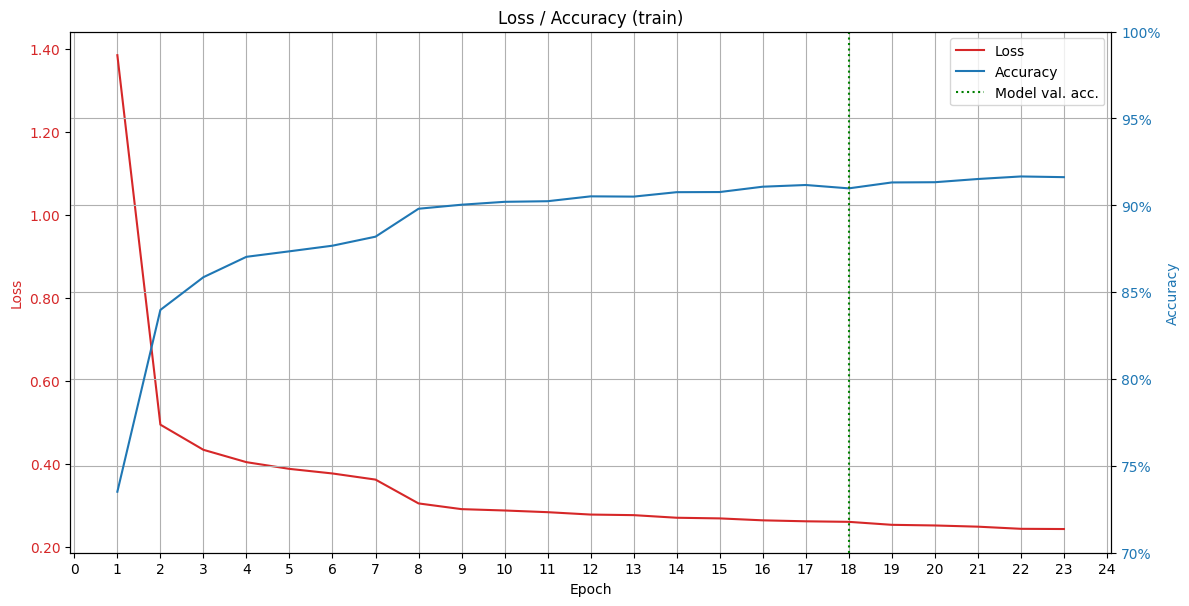

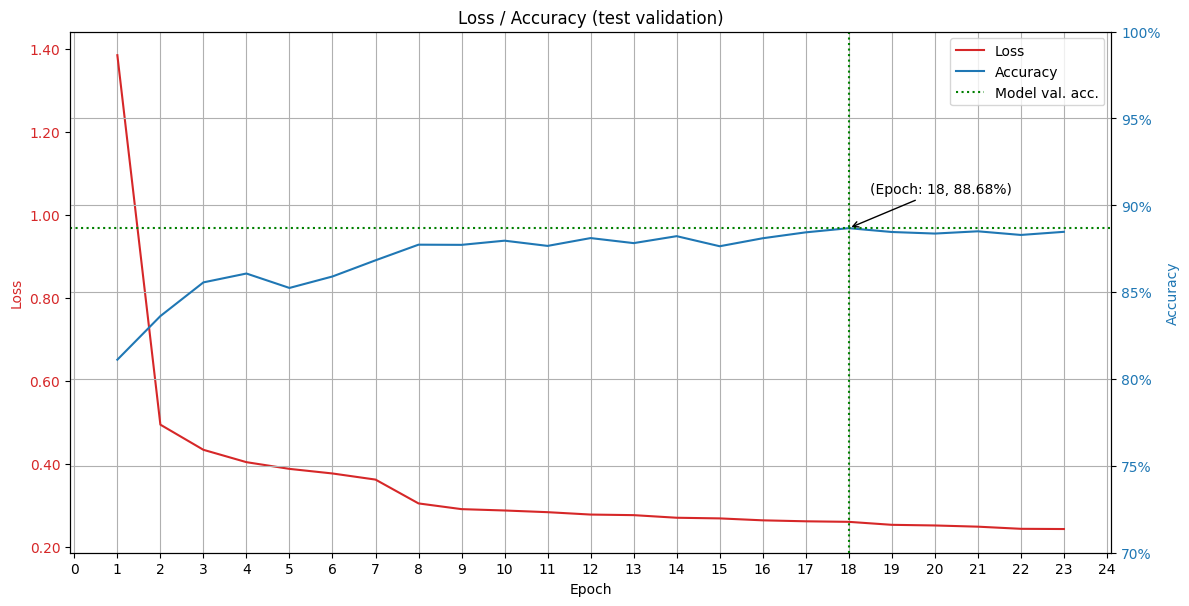

In [14]:
# @title
def pair_plot(loss_history, accuracy_history, title, closest_index = None, model_accuracy=None):

  fig, ax1 = plt.subplots()
  fig.set_size_inches((12,6))

  color = 'tab:red'
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss', color=color)
  ax1.plot(loss_history, color=color, label="Loss")
  ax1.tick_params(axis='y', labelcolor=color)
  ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int((x + 1))))
  if len(loss_history) < 40 :
    ax1.xaxis.set_major_locator(MultipleLocator(1))
  ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{(y):.2f}'))
  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

  color = 'tab:blue'
  ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
  p2=ax2.plot(accuracy_history, color=color, label="Accuracy")
  ax2.tick_params(axis='y', labelcolor=color)
  ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
  ax2.grid()
  ax1.xaxis.grid(True)
  ax2.set_ylim([0.7, 1.0])

  if closest_index:
    ax2.axvline(x=closest_index, color='green', linestyle='dotted', label="Model val. acc.")
    if model_accuracy:
      ax2.axhline(y=model_accuracy, color='green', linestyle='dotted')
      intersection_text = f'(Epoch: {closest_index+1}, {model_accuracy:.2%})'
      ax2.annotate(intersection_text, xy=(closest_index, model_accuracy), xytext=(closest_index + 0.5, model_accuracy + 0.02),
                  arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10)


  # Combine the legends from ax1 and ax2
  lines, labels_ = ax1.get_legend_handles_labels()
  lines2, labels2 = ax2.get_legend_handles_labels()
  ax2.legend(lines + lines2, labels_ + labels2, loc='best')

  fig.tight_layout()  # otherwise the right y-label is slightly clipped
  plt.title(title)
  plt.show()

loss_history = models_his[model_name].history['loss']
accuracy_history = models_his[model_name].history['accuracy']
val_loss_history = models_his[model_name].history['loss']
val_accuracy_history = models_his[model_name].history['val_accuracy']

closest_epoch_index = np.argmin(np.abs(np.array(val_accuracy_history) - results[model_name][1]))


pair_plot(loss_history, accuracy_history, "Loss / Accuracy (train)", closest_epoch_index)
pair_plot(val_loss_history, val_accuracy_history, "Loss / Accuracy (test validation)", closest_epoch_index, results[model_name][1])

## Додаємо модель НМ версію 1 (IL-HL1-HL2-HL3-HL4-OL) без регулярізації L2 в "HL2"

In [15]:
model_name = "Model_1_no_reg"

models[model_name] = Sequential([
    Flatten(input_shape=x_train.shape[1:], name="INPUT"),
    Dense(n_hidden_1, activation='relu', name="Hidden_Layer_1"),
    Dense(n_hidden_2, activation='relu', kernel_regularizer=None, name="Hidden_Layer_2"),
    Dense(256, activation='relu', name="Hidden_Layer_3"),
    Dense(32, activation='relu', name="Hidden_Layer_4"),
    Dense(num_classes, activation='softmax', name="OUTPUT"),
],name=model_name)

models_his[model_name]  = compile_and_fit(models[model_name], model_name, batch_size=batch_size, max_epochs=epochs)
results[model_name] = models[model_name].evaluate(x_test, y_test, verbose=True)
print(results[model_name])

Model: "Model_1_no_reg"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (Flatten)             (None, 784)               0         
                                                                 
 Hidden_Layer_1 (Dense)      (None, 256)               200960    
                                                                 
 Hidden_Layer_2 (Dense)      (None, 512)               131584    
                                                                 
 Hidden_Layer_3 (Dense)      (None, 256)               131328    
                                                                 
 Hidden_Layer_4 (Dense)      (None, 32)                8224      
                                                                 
 OUTPUT (Dense)              (None, 10)                330       
                                                                 
Total params: 472426 (1.80 MB)
Trainable params: 472

## Додаємо нову модель НМ версія 1 (IL-HL1-HL2-HL3-HL4-OL) з регулярізацією L2 0.1 в "HL2"

In [16]:
model_name = "Model_1_L2_0.1"

kernel_regularizer_1 = regularizers.l2(0.1)

models[model_name] = Sequential([
    Flatten(input_shape=x_train.shape[1:], name="INPUT"),
    Dense(n_hidden_1, activation='relu', name="Hidden_Layer_1"),
    Dense(n_hidden_2, activation='relu', kernel_regularizer=kernel_regularizer_1, name="Hidden_Layer_2"),
    Dense(256, activation='relu', name="Hidden_Layer_3"),
    Dense(32, activation='relu', name="Hidden_Layer_4"),
    Dense(num_classes, activation='softmax', name="OUTPUT"),
],name=model_name)

models_his[model_name] = compile_and_fit(models[model_name], model_name, batch_size=batch_size, max_epochs=epochs)
results[model_name] = models[model_name].evaluate(x_test, y_test, verbose=True)
print(results[model_name])

Model: "Model_1_L2_0.1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (Flatten)             (None, 784)               0         
                                                                 
 Hidden_Layer_1 (Dense)      (None, 256)               200960    
                                                                 
 Hidden_Layer_2 (Dense)      (None, 512)               131584    
                                                                 
 Hidden_Layer_3 (Dense)      (None, 256)               131328    
                                                                 
 Hidden_Layer_4 (Dense)      (None, 32)                8224      
                                                                 
 OUTPUT (Dense)              (None, 10)                330       
                                                                 
Total params: 472426 (1.80 MB)
Trainable params: 472

## Додаємо нову модель НМ версія 2 (IL-HL1-HL2-OL), ативаційна функція 'relu'

In [17]:
model_name = "Model_2"

models[model_name] = Sequential([
    Flatten(input_shape=x_train.shape[1:], name="INPUT"),
    Dense(n_hidden_1, activation='relu', name="Hidden_Layer_1"),
    Dense(n_hidden_2, activation='relu', kernel_regularizer=None, name="Hidden_Layer_2"),
    Dense(num_classes, activation='softmax', name="OUTPUT"),
],name=model_name)

models_his[model_name] = compile_and_fit(models[model_name], model_name, batch_size=batch_size, max_epochs=epochs)
results[model_name] = models[model_name].evaluate(x_test, y_test, verbose=True)
print(results[model_name])

Model: "Model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (Flatten)             (None, 784)               0         
                                                                 
 Hidden_Layer_1 (Dense)      (None, 256)               200960    
                                                                 
 Hidden_Layer_2 (Dense)      (None, 512)               131584    
                                                                 
 OUTPUT (Dense)              (None, 10)                5130      
                                                                 
Total params: 337674 (1.29 MB)
Trainable params: 337674 (1.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
313/313 [==============================] - 4s 9ms/step - loss: 0.3133 - accuracy: 0.8947
[0.3132914900779724, 0.8946999907493591]


## Додаємо нову модель НМ версія 2 (IL-HL1-HL2-OL) L2 (0.1)

In [18]:
model_name = "Model_2_L2_0.1"

kernel_regularizer_2 = regularizers.l2(0.1)

models[model_name] = Sequential([
    Flatten(input_shape=x_train.shape[1:], name="INPUT"),
    Dense(n_hidden_1, activation='relu', name="Hidden_Layer_1"),
    Dense(n_hidden_2, activation='relu', kernel_regularizer=kernel_regularizer_2, name="Hidden_Layer_2"),
    Dense(num_classes, activation='softmax', name="OUTPUT"),
],name=model_name)

history = compile_and_fit(models[model_name], model_name, batch_size=batch_size, max_epochs=epochs)
models_his[model_name] = history
results[model_name] = models[model_name].evaluate(x_test, y_test, verbose=True)
print(results[model_name])

Model: "Model_2_L2_0.1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (Flatten)             (None, 784)               0         
                                                                 
 Hidden_Layer_1 (Dense)      (None, 256)               200960    
                                                                 
 Hidden_Layer_2 (Dense)      (None, 512)               131584    
                                                                 
 OUTPUT (Dense)              (None, 10)                5130      
                                                                 
Total params: 337674 (1.29 MB)
Trainable params: 337674 (1.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
313/313 [==============================] - 3s 8ms/step - loss: 0.3688 - accuracy: 0.8818
[0.3687952160835266, 0.8817999958992004]


## Додаємо нову модель НМ версія 2 (IL-HL1-HL2-OL) з L2 (1.0)

In [19]:
model_name = "Model_2_L2_1"

kernel_regularizer_2 = regularizers.l2(1)

models[model_name] = Sequential([
    Flatten(input_shape=x_train.shape[1:], name="INPUT"),
    Dense(n_hidden_1, activation='relu', name="Hidden_Layer_1"),
    Dense(n_hidden_2, activation='relu', kernel_regularizer=kernel_regularizer_2, name="Hidden_Layer_2"),
    Dense(num_classes, activation='softmax', name="OUTPUT"),
],name=model_name)

history = compile_and_fit(models[model_name], model_name, batch_size=batch_size, max_epochs=epochs)
models_his[model_name] = history
results[model_name] = models[model_name].evaluate(x_test, y_test, verbose=True)
print(results[model_name])

Model: "Model_2_L2_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (Flatten)             (None, 784)               0         
                                                                 
 Hidden_Layer_1 (Dense)      (None, 256)               200960    
                                                                 
 Hidden_Layer_2 (Dense)      (None, 512)               131584    
                                                                 
 OUTPUT (Dense)              (None, 10)                5130      
                                                                 
Total params: 337674 (1.29 MB)
Trainable params: 337674 (1.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
313/313 [==============================] - 3s 7ms/step - loss: 0.4418 - accuracy: 0.8627
[0.44175025820732117, 0.8626999855041504]


## Додаємо нову модель НМ версія 3 (IL-HL1-HL2-OL) з Dropout (0.2)

In [20]:
model_name = "Model_3_DO_0.2"
dropout_prob = 0.2

models[model_name] = Sequential([
    Flatten(input_shape=x_train.shape[1:], name="INPUT"),
    Dropout(dropout_prob),
    Dense(n_hidden_1, activation='relu', name="Hidden_Layer_1"),
    Dropout(dropout_prob),
    Dense(n_hidden_2, activation='relu',  name="Hidden_Layer_2"),
    Dropout(dropout_prob),
    Dense(num_classes, activation='softmax', name="OUTPUT"),
],name=model_name)

models_his[model_name] = compile_and_fit(models[model_name], model_name, batch_size=batch_size, max_epochs=epochs)
results[model_name] = models[model_name].evaluate(x_test, y_test, verbose=True)
print(results[model_name])

Model: "Model_3_DO_0.2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (Flatten)             (None, 784)               0         
                                                                 
 dropout (Dropout)           (None, 784)               0         
                                                                 
 Hidden_Layer_1 (Dense)      (None, 256)               200960    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 Hidden_Layer_2 (Dense)      (None, 512)               131584    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 OUTPUT (Dense)              (None, 10)             

## Додаємо нову модель НМ версія 3 (IL-HL1-HL2-OL) з Dropout (0.5)

In [21]:
model_name = "Model_3_DO_0.5"
dropout_prob = 0.5

models[model_name] = Sequential([
    Flatten(input_shape=x_train.shape[1:], name="INPUT"),
    Dropout(dropout_prob),
    Dense(n_hidden_1, activation='relu', name="Hidden_Layer_1"),
    Dropout(dropout_prob),
    Dense(n_hidden_2, activation='relu',  name="Hidden_Layer_2"),
    Dropout(dropout_prob),
    Dense(num_classes, activation='softmax', name="OUTPUT"),
],name=model_name)

history = compile_and_fit(models[model_name], model_name, batch_size=batch_size, max_epochs=epochs)
models_his[model_name] = history
results[model_name] = models[model_name].evaluate(x_test, y_test, verbose=True)
print(results[model_name])

Model: "Model_3_DO_0.5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (Flatten)             (None, 784)               0         
                                                                 
 dropout_3 (Dropout)         (None, 784)               0         
                                                                 
 Hidden_Layer_1 (Dense)      (None, 256)               200960    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 Hidden_Layer_2 (Dense)      (None, 512)               131584    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 OUTPUT (Dense)              (None, 10)             

## Додаємо нову модель НМ версія 2 (IL-HL1-HL2-OL) з функцією активації leaky_relu

In [22]:
model_name = "Model_2_lrelu"

models[model_name] = Sequential([
    Flatten(input_shape=x_train.shape[1:], name="INPUT"),
    Dense(n_hidden_1, activation='leaky_relu', name="Hidden_Layer_1"),
    Dense(n_hidden_2, activation='leaky_relu',  name="Hidden_Layer_2"),
    Dense(num_classes, activation='softmax', name="OUTPUT"),
],name=model_name)

models_his[model_name] = compile_and_fit(models[model_name], model_name, batch_size=batch_size, max_epochs=epochs)
results[model_name] = models[model_name].evaluate(x_test, y_test, verbose=True)
print(results[model_name])

Model: "Model_2_lrelu"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (Flatten)             (None, 784)               0         
                                                                 
 Hidden_Layer_1 (Dense)      (None, 256)               200960    
                                                                 
 Hidden_Layer_2 (Dense)      (None, 512)               131584    
                                                                 
 OUTPUT (Dense)              (None, 10)                5130      
                                                                 
Total params: 337674 (1.29 MB)
Trainable params: 337674 (1.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
313/313 [==============================] - 1s 3ms/step - loss: 0.3157 - accuracy: 0.8896
[0.3157041072845459, 0.8895999789237976]


## Додаємо нову модель НМ версія 2 (IL-HL1-HL2-OL) з функцією активації leaky_relu, batch size 32.

In [23]:
model_name = "Model_2_lrelu_b32"

models[model_name] = Sequential([
    Flatten(input_shape=x_train.shape[1:], name="INPUT"),
    Dense(n_hidden_1, activation='leaky_relu', name="Hidden_Layer_1"),
    Dense(n_hidden_2, activation='leaky_relu',  name="Hidden_Layer_2"),
    Dense(num_classes, activation='softmax', name="OUTPUT"),
],name=model_name)

models_his[model_name] = compile_and_fit(models[model_name], model_name, batch_size=32, max_epochs=epochs)
results[model_name] = models[model_name].evaluate(x_test, y_test, verbose=True)
print(results[model_name])

Model: "Model_2_lrelu_b32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (Flatten)             (None, 784)               0         
                                                                 
 Hidden_Layer_1 (Dense)      (None, 256)               200960    
                                                                 
 Hidden_Layer_2 (Dense)      (None, 512)               131584    
                                                                 
 OUTPUT (Dense)              (None, 10)                5130      
                                                                 
Total params: 337674 (1.29 MB)
Trainable params: 337674 (1.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
313/313 [==============================] - 1s 3ms/step - loss: 0.3648 - accuracy: 0.8798
[0.36477646231651306, 0.879800021648407]


## Додаємо нову модель НМ версія 2 (IL-HL1-HL2-OL) з функцією активації leaky_relu, optimizer SGD.

In [47]:
model_name = "Model_2_lrelu_sgd"

models[model_name] = Sequential([
    Flatten(input_shape=x_train.shape[1:], name="INPUT"),
    Dense(n_hidden_1, activation='leaky_relu', name="Hidden_Layer_1"),
    Dense(n_hidden_2, activation='leaky_relu',  name="Hidden_Layer_2"),
    Dense(num_classes, activation='softmax', name="OUTPUT"),
],name=model_name)

optimizer = optimizers.SGD(learning_rate=0.05)
shedule_ = lambda e,l: scheduler_exp(epoch=e, lr=l, thresh=10)
models_his[model_name] = compile_and_fit(models[model_name], model_name, max_epochs=100, optimizer=optimizer, shedule=shedule_)
results[model_name] = models[model_name].evaluate(x_test, y_test, verbose=True)
print(results[model_name])

Model: "Model_2_lrelu_sgd"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (Flatten)             (None, 784)               0         
                                                                 
 Hidden_Layer_1 (Dense)      (None, 256)               200960    
                                                                 
 Hidden_Layer_2 (Dense)      (None, 512)               131584    
                                                                 
 OUTPUT (Dense)              (None, 10)                5130      
                                                                 
Total params: 337674 (1.29 MB)
Trainable params: 337674 (1.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
117/118 [============================>.] - ETA: 0s - loss: 1.0255 - accuracy: 0.6713
Epoch 1: val_accuracy improved from -inf to 0.73

## Додаємо нову модель НМ версія 2 (IL-HL1-HL2-OL) з функцією активації leaky_relu, BatchNormalization,

In [59]:
model_name = "Model_2_lrelu_bnorm"

models[model_name] = Sequential([
    Flatten(input_shape=x_train.shape[1:], name="INPUT"),
    Dense(n_hidden_1, activation='leaky_relu', name="Hidden_Layer_1"),
    BatchNormalization(),
    Dense(n_hidden_2, activation='leaky_relu',  name="Hidden_Layer_2"),
    BatchNormalization(),
    Dense(num_classes, activation='softmax', name="OUTPUT"),
],name=model_name)

models_his[model_name] = compile_and_fit(models[model_name], model_name, batch_size=batch_size, max_epochs=epochs)
results[model_name] = models[model_name].evaluate(x_test, y_test, verbose=True)
print(results[model_name])

Model: "Model_2_lrelu_bnorm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (Flatten)             (None, 784)               0         
                                                                 
 Hidden_Layer_1 (Dense)      (None, 256)               200960    
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 Hidden_Layer_2 (Dense)      (None, 512)               131584    
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 OUTPUT (Dense)              (None, 10)        

In [101]:
# @title
def summarize(h, name, results=None):
    print(f"Summarize for: {name}")
    # plot loss
    closest_epoch_index = None
    if results:
      closest_epoch_index_val_loss = np.argmin(np.abs(np.array(h.history['val_loss']) - results[0]))
      closest_epoch_index_val_acc = np.argmin(np.abs(np.array(h.history['val_accuracy']) - results[1]))
      closest_epoch_index = min(closest_epoch_index_val_loss, closest_epoch_index_val_acc)
      stop_dist = len(h.history['val_loss'])-closest_epoch_index-1
      print(f"{closest_epoch_index=}, {stop_dist=}")
      why_stop = "epoch"
      if stop_dist >= loss_patience and stop_dist < accurqcy_patience:
        why_stop = "loss"
      elif stop_dist >= accurqcy_patience:
        why_stop = "accuracy"

    plt.figure(figsize=(12,8))
    plt.subplot(2, 1, 1)
    plt.title(f'Cross Entropy Loss {name}')
    if closest_epoch_index:
      plt.axvline(x=closest_epoch_index, color='green', linestyle='dotted', label=f"Early stop: {closest_epoch_index+1} ({why_stop})")
      model_accuracy = h.history['val_loss'][closest_epoch_index]
      intersection_text = 'Lowest value'
      plt.annotate(intersection_text, xy=(closest_epoch_index, model_accuracy), xytext=(closest_epoch_index + 0.5, model_accuracy + 0.1),
                  arrowprops=dict(facecolor='green', edgecolor='green', arrowstyle='->'),
                   fontsize=8, color='green',bbox=dict(facecolor='white', edgecolor='green', alpha=0.8) )

    plt.plot(h.history['loss'], color='blue', label='train')
    plt.plot(h.history['val_loss'], "--", color='orange', label='test')
    axis = plt.gca()
    axis.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int((x + 1))))
    max_x_value = len(h.history['loss'])
    if max_x_value < 55:
      axis.xaxis.set_major_locator(FixedLocator(range(0, max_x_value)))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim(0,1)
    plt.xlim(0,max_x_value-1)
    plt.legend()
    plt.grid()
    plt.tight_layout(pad=3.0)
    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.title(f'Classification Accuracy {name}')
    if closest_epoch_index:
      plt.axvline(x=closest_epoch_index, color='green', linestyle='dotted', label=f"Early stop: {closest_epoch_index+1} ({why_stop})")

      model_accuracy = h.history['val_accuracy'][closest_epoch_index]
      intersection_text = f'({model_accuracy:.2%})'
      plt.annotate(intersection_text, xy=(closest_epoch_index, model_accuracy), xytext=(closest_epoch_index + 0.5, model_accuracy - 0.05),
                  arrowprops=dict(facecolor='green', edgecolor='green', arrowstyle='->'),
                   fontsize=8, color='green',bbox=dict(facecolor='white', edgecolor='green', alpha=0.8) )

    plt.plot(h.history['accuracy'], color='blue', label='train')
    plt.plot(h.history['val_accuracy'], "--", color='orange', label='test')
    axis = plt.gca()
    axis.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int((x + 1))))
    if max_x_value < 55:
      axis.xaxis.set_major_locator(FixedLocator(range(0, max_x_value)))
    axis.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0.7,1)
    plt.xlim(0,max_x_value-1)
    plt.grid()
    plt.show()

In [61]:
# save_all()
zip_files()

Creating {model_zip}
updating: Model_1_L2_0.025_model.keras (deflated 8%)
updating: Model_1_L2_0.1_model.keras (deflated 7%)
updating: Model_1_no_reg_model.keras (deflated 7%)
updating: Model_2_L2_0.1_model.keras (deflated 6%)
updating: Model_2_L2_1_model.keras (deflated 6%)
updating: Model_2_lrelu_b32_model.keras (deflated 7%)
updating: Model_2_lrelu_model.keras (deflated 8%)
updating: Model_2_lrelu_sgd_model.keras (deflated 8%)
updating: Model_2_model.keras (deflated 7%)
updating: Model_3_DO_0.2_model.keras (deflated 7%)
updating: Model_3_DO_0.5_model.keras (deflated 7%)
updating: Model_1_L2_0.025_history.pikle (deflated 8%)
updating: Model_1_L2_0.1_history.pikle (deflated 7%)
updating: Model_1_no_reg_history.pikle (deflated 7%)
updating: Model_2_history.pikle (deflated 7%)
updating: Model_2_L2_0.1_history.pikle (deflated 6%)
updating: Model_2_L2_1_history.pikle (deflated 6%)
updating: Model_2_lrelu_b32_history.pikle (deflated 7%)
updating: Model_2_lrelu_history.pikle (deflated 7%)
u

Summarize for: (Model_1_L2_0.025)
closest_epoch_index=17, stop_dist=5


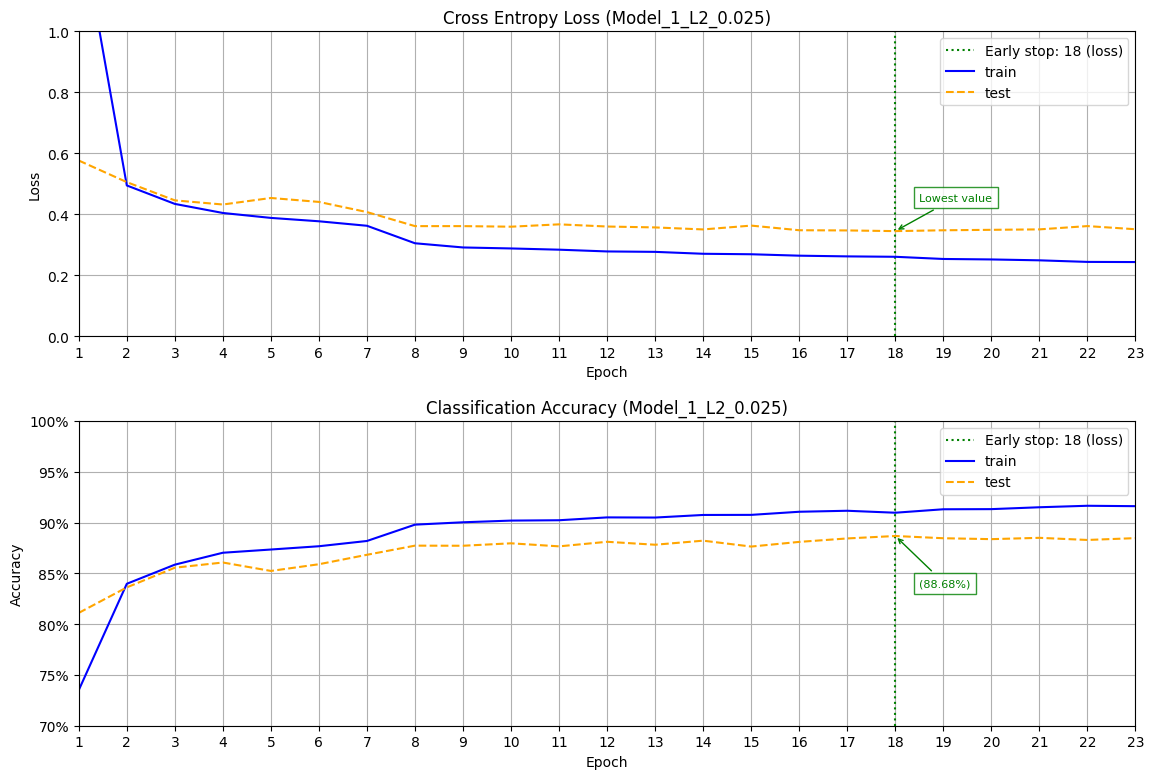

Summarize for: (Model_1_no_reg)
closest_epoch_index=11, stop_dist=5


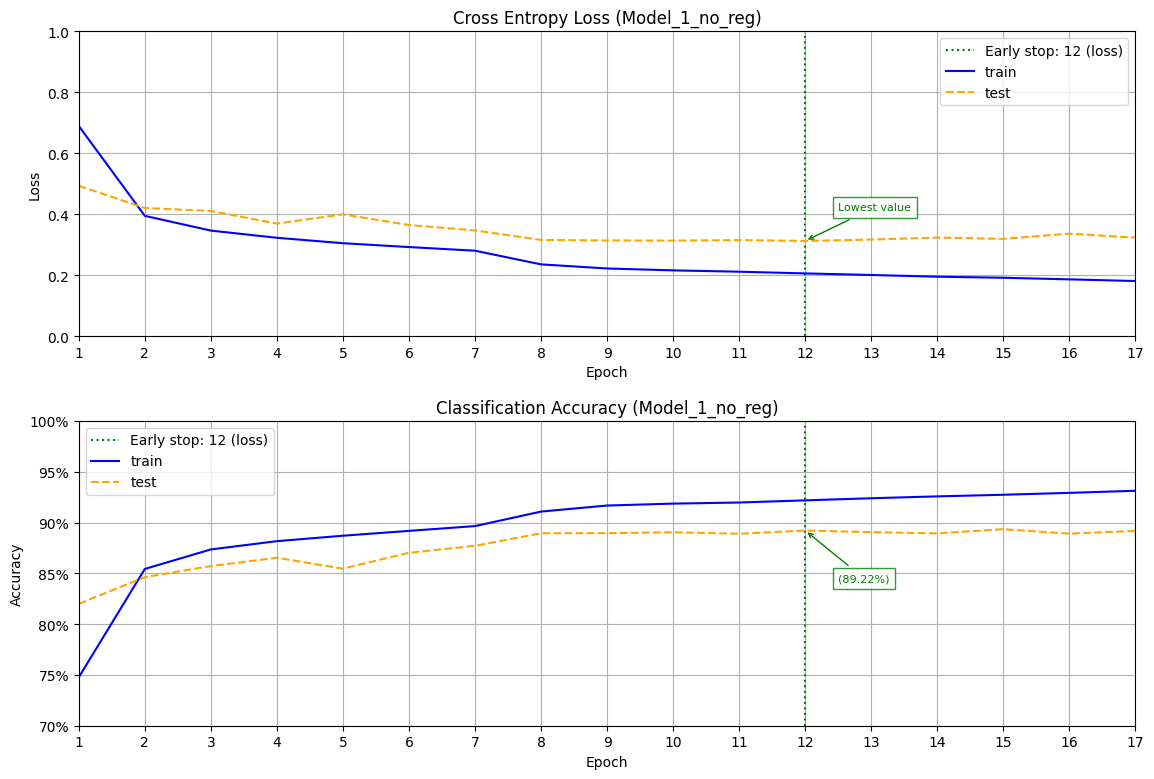

Summarize for: (Model_1_L2_0.1)
closest_epoch_index=11, stop_dist=5


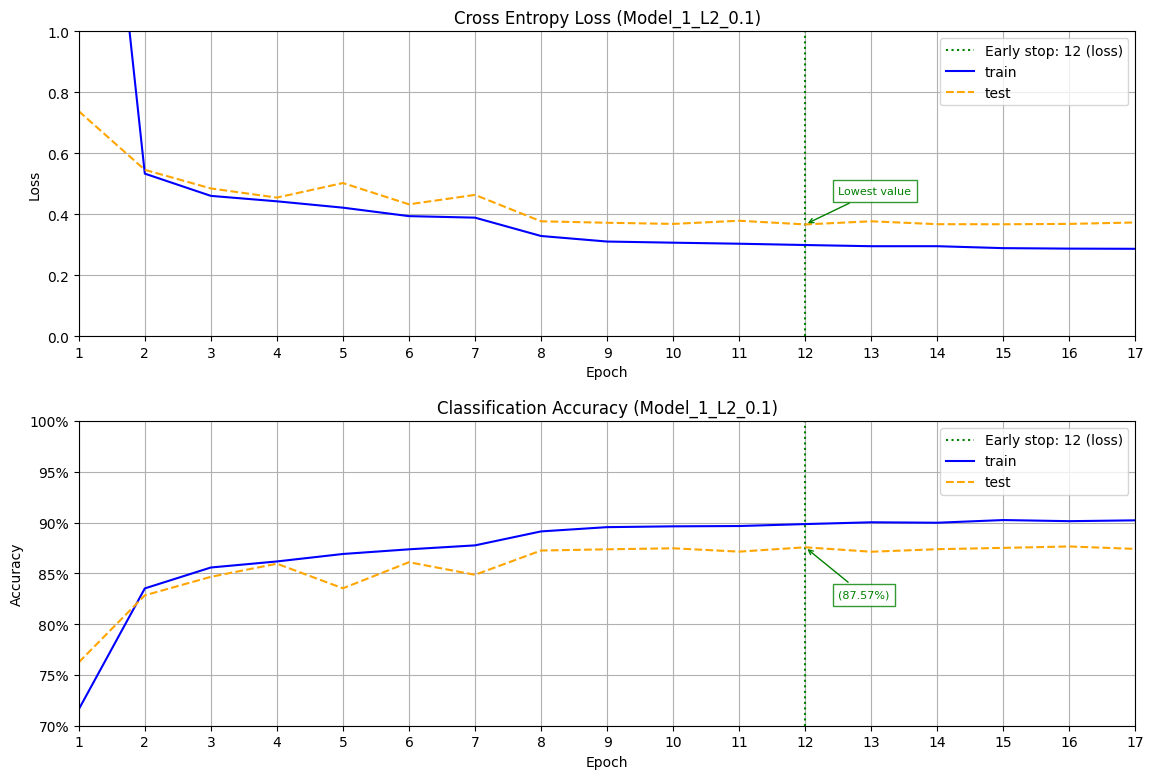

Summarize for: (Model_2)
closest_epoch_index=10, stop_dist=5


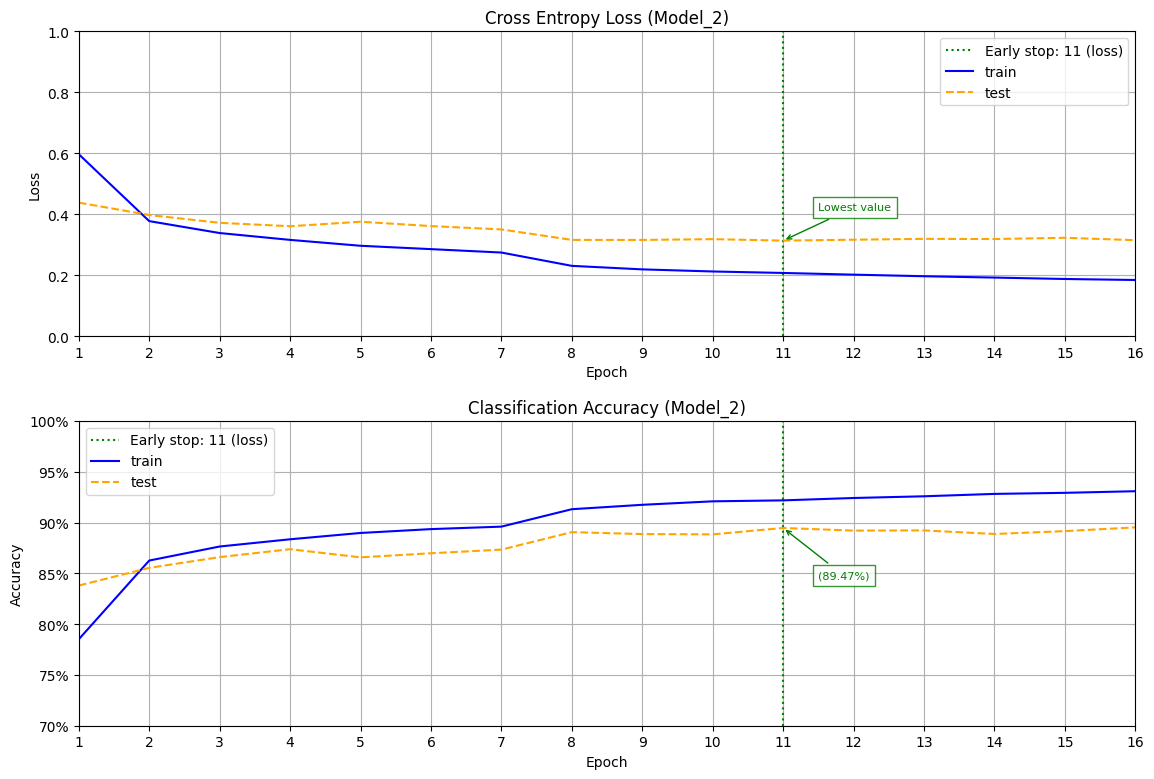

Summarize for: (Model_2_L2_0.1)
closest_epoch_index=29, stop_dist=5


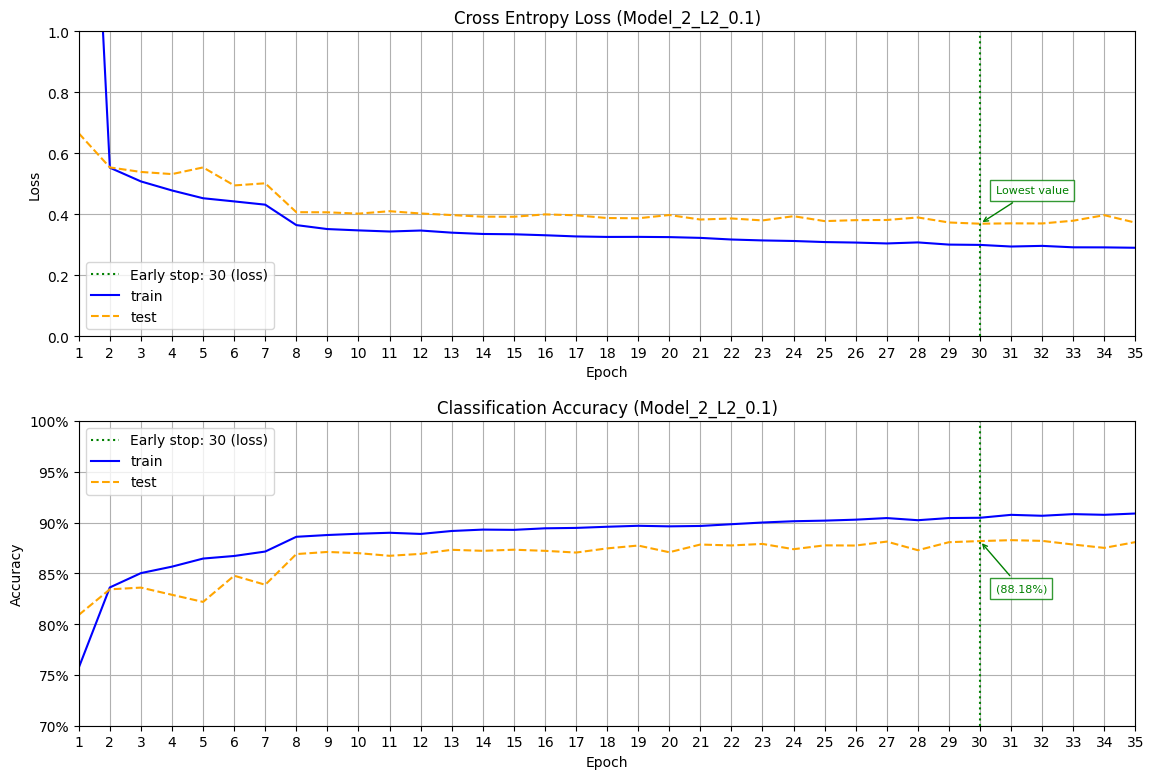

Summarize for: (Model_2_L2_1)
closest_epoch_index=21, stop_dist=5


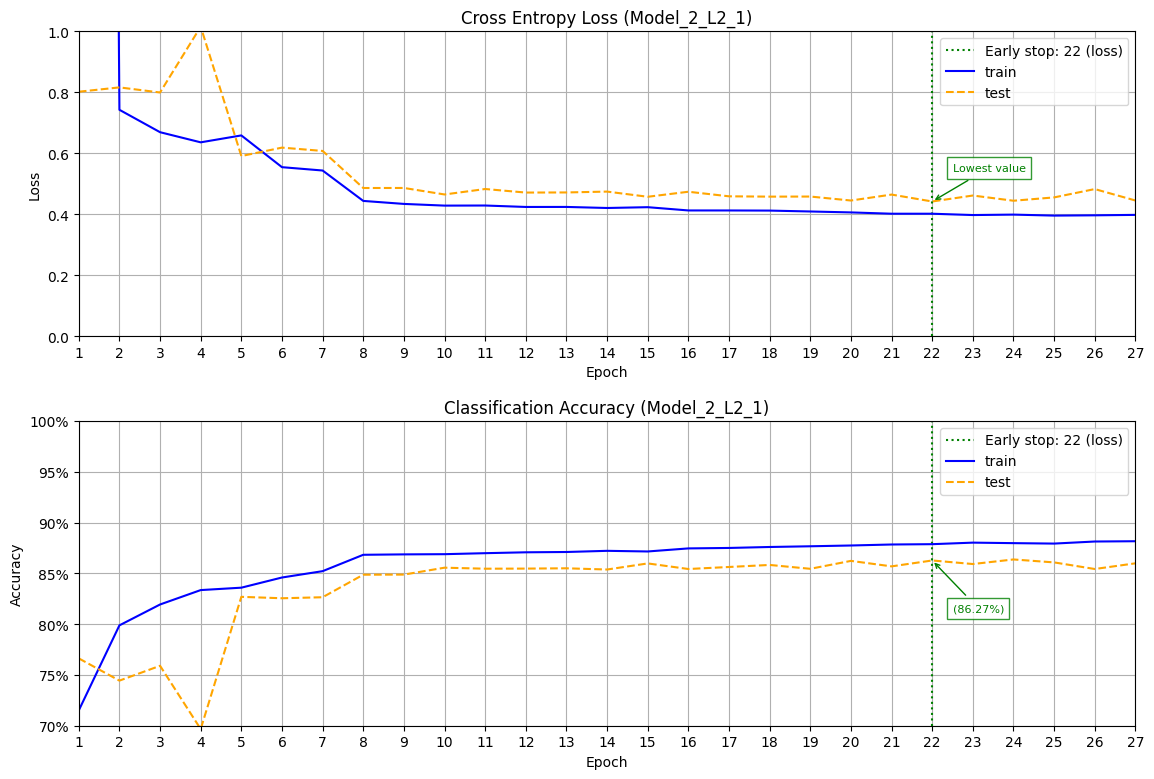

Summarize for: (Model_3_DO_0.2)
closest_epoch_index=48, stop_dist=5


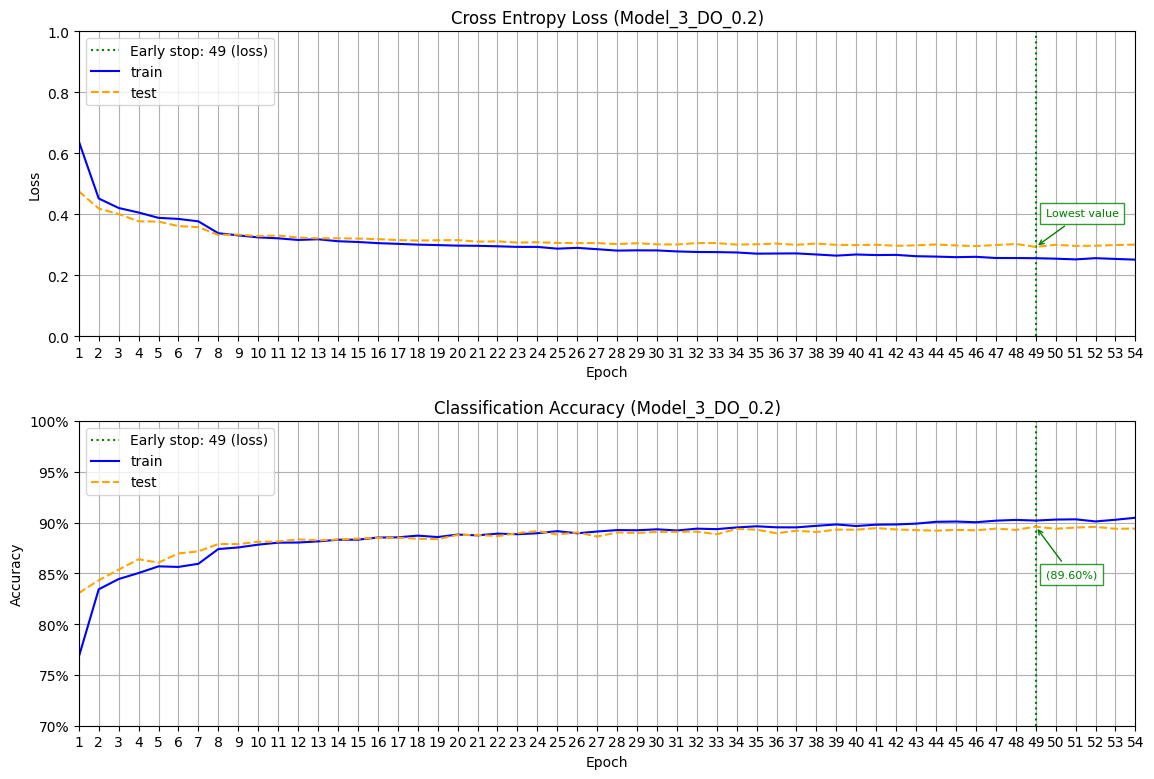

Summarize for: (Model_3_DO_0.5)
closest_epoch_index=21, stop_dist=5


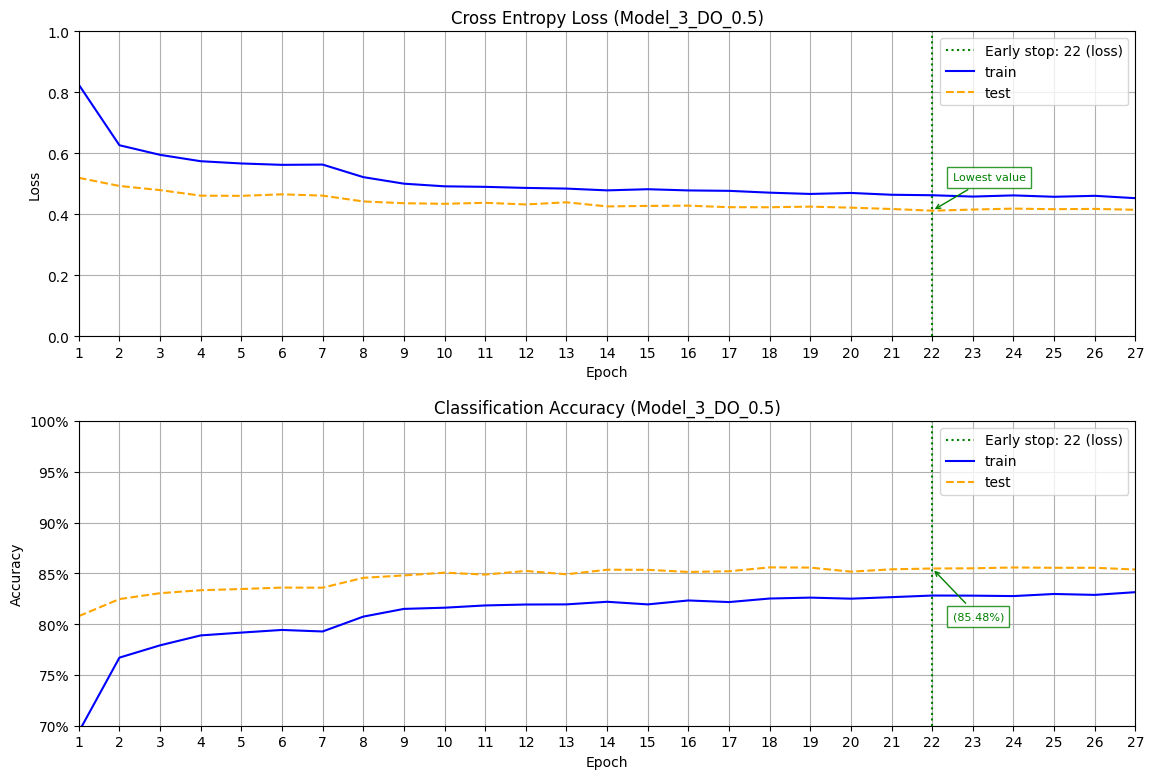

Summarize for: (Model_2_lrelu)
closest_epoch_index=11, stop_dist=5


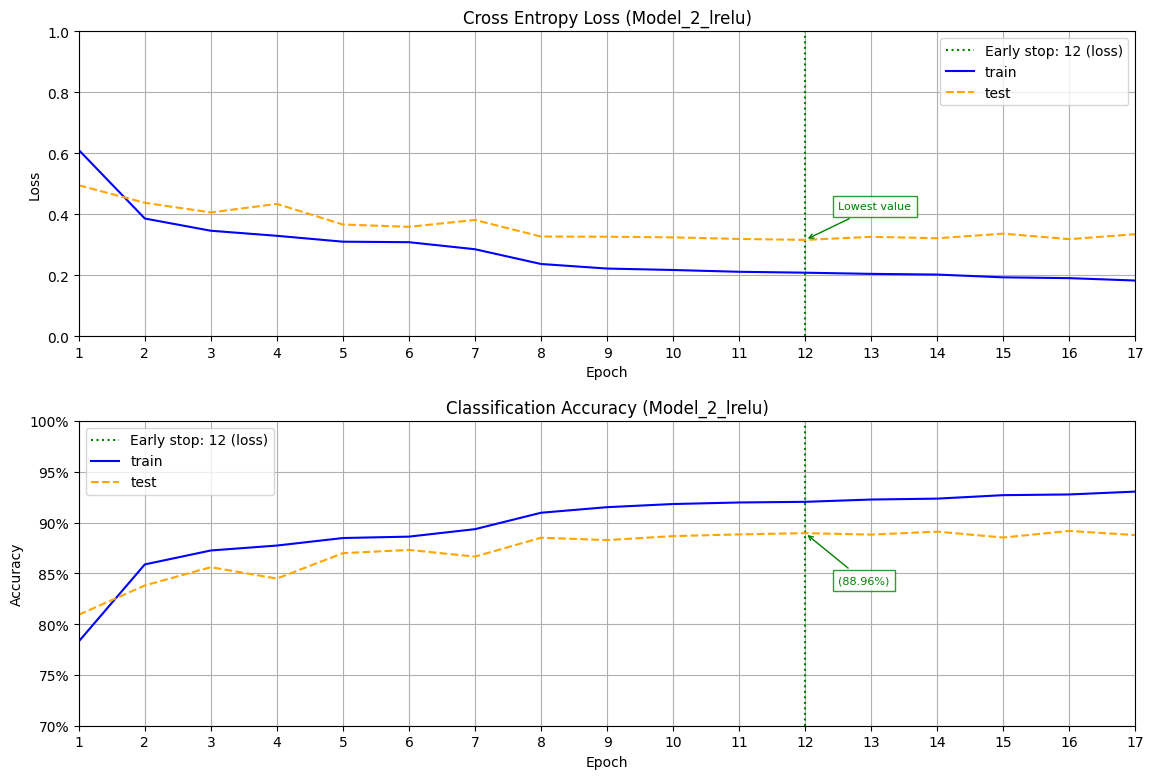

Summarize for: (Model_2_lrelu_b32)
closest_epoch_index=9, stop_dist=6


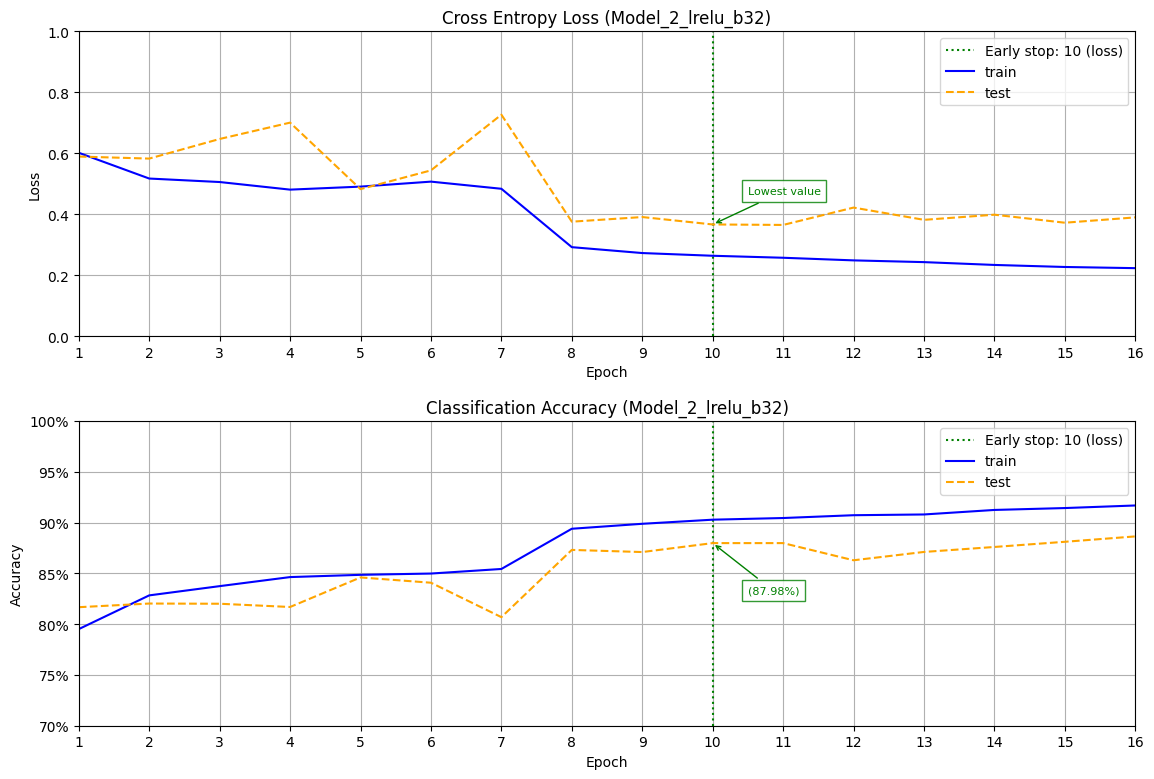

Summarize for: (Model_2_lrelu_sgd)
closest_epoch_index=37, stop_dist=10


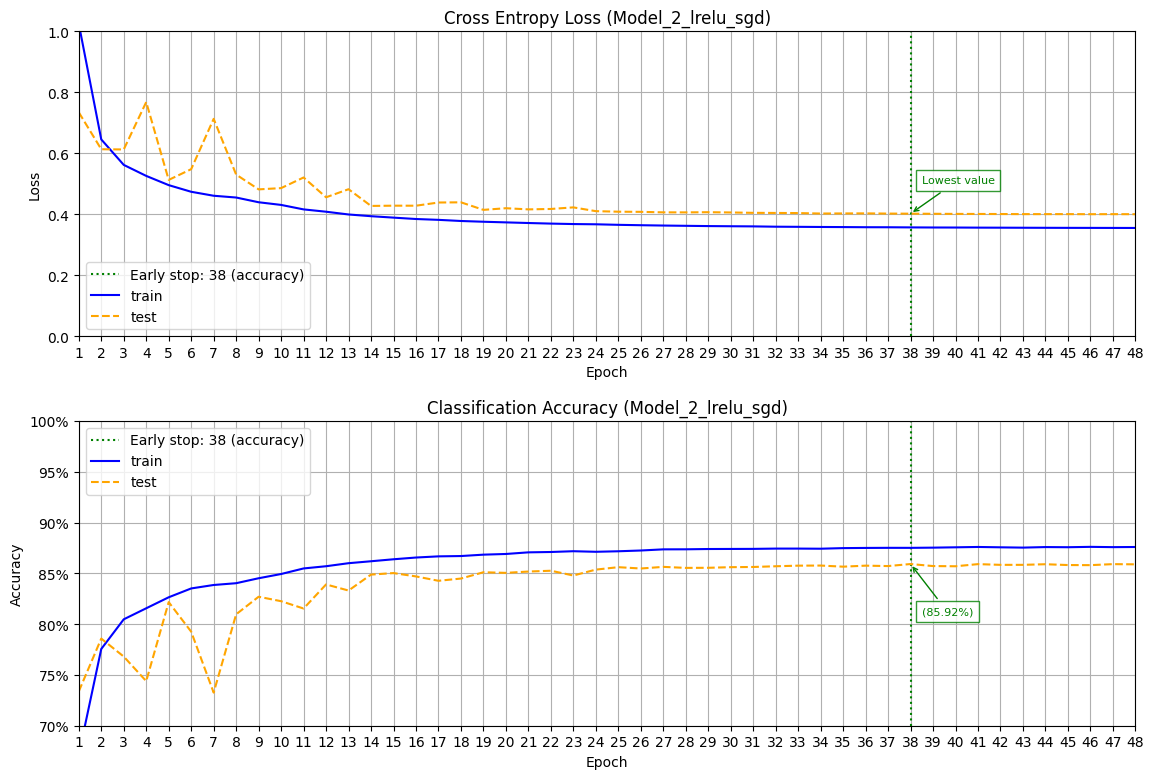

Summarize for: (Model_2_lrelu_bnorm)
closest_epoch_index=9, stop_dist=5


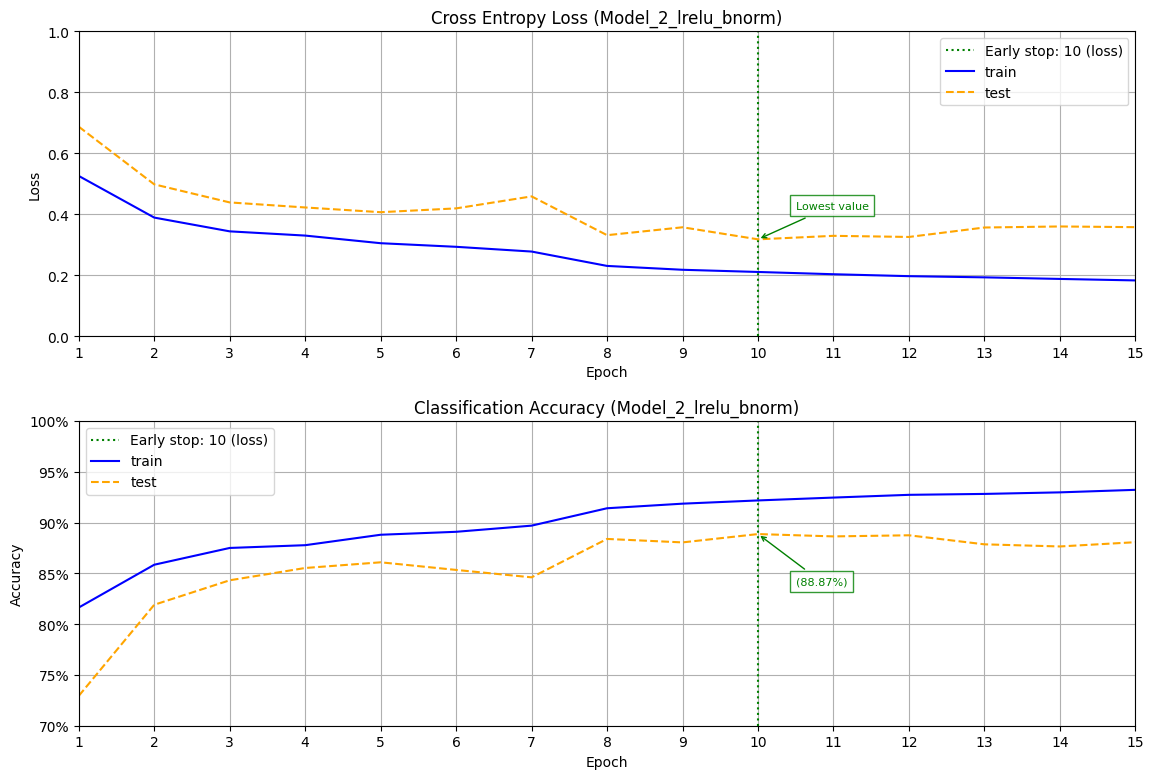

In [102]:
for name, models_h in models_his.items():
  #print(name)
  summarize(models_h, f"({name})", results[name])

## Сумарний звіт

## Reports

In [103]:
test_pred_values = {}
test_pred = {}
for name, models_h in models_his.items():
  print(name,models[name].name)
  test_pred[name] = models[name].predict(x_test, batch_size=batch_size, use_multiprocessing=True)
  test_pred_values[name] = tf.math.argmax(test_pred[name], axis=1)

Model_1_L2_0.025 Model_1_L2_0.025
20/20 [==============================] - 0s 12ms/step
Model_1_no_reg Model_1_no_reg
20/20 [==============================] - 0s 13ms/step
Model_1_L2_0.1 Model_1_L2_0.1
20/20 [==============================] - 0s 16ms/step
Model_2 Model_2
20/20 [==============================] - 0s 18ms/step
Model_2_L2_0.1 Model_2_L2_0.1
20/20 [==============================] - 0s 15ms/step
Model_2_L2_1 Model_2_L2_1
20/20 [==============================] - 0s 17ms/step
Model_3_DO_0.2 Model_3_DO_0.2
20/20 [==============================] - 0s 18ms/step
Model_3_DO_0.5 Model_3_DO_0.5
20/20 [==============================] - 0s 16ms/step
Model_2_lrelu Model_2_lrelu
20/20 [==============================] - 0s 15ms/step
Model_2_lrelu_b32 Model_2_lrelu_b32
20/20 [==============================] - 0s 16ms/step
Model_2_lrelu_sgd Model_2_lrelu_sgd
20/20 [==============================] - 0s 11ms/step
Model_2_lrelu_bnorm Model_2_lrelu_bnorm
20/20 [==============================] -

Classification report for: 'Model_1_L2_0.025'
                 precision    recall  f1-score   support

0 - T-shirt/top       0.81      0.89      0.85      1000
1 - Trouser           0.98      0.97      0.98      1000
2 - Pullover          0.82      0.79      0.80      1000
3 - Dress             0.88      0.89      0.89      1000
4 - Coat              0.78      0.83      0.80      1000
5 - Sandal            0.97      0.96      0.97      1000
6 - Shirt             0.75      0.65      0.69      1000
7 - Sneaker           0.94      0.96      0.95      1000
8 - Bag               0.97      0.98      0.97      1000
9 - Ankle boot        0.96      0.96      0.96      1000

       accuracy                           0.89     10000
      macro avg       0.89      0.89      0.89     10000
   weighted avg       0.89      0.89      0.89     10000

Accuracy: 88.68%, ROC-AUC: 0.9906

Confusion matrix for: 'Model_1_L2_0.025'


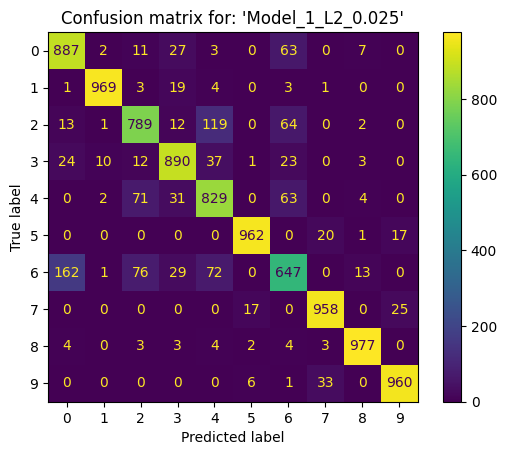

['0 - T-shirt/top', '1 - Trouser', '2 - Pullover', '3 - Dress', '4 - Coat', '5 - Sandal', '6 - Shirt', '7 - Sneaker', '8 - Bag', '9 - Ankle boot']
------------------------------------------------------------ 

Classification report for: 'Model_1_no_reg'
                 precision    recall  f1-score   support

0 - T-shirt/top       0.84      0.86      0.85      1000
1 - Trouser           0.99      0.98      0.98      1000
2 - Pullover          0.83      0.80      0.81      1000
3 - Dress             0.88      0.91      0.89      1000
4 - Coat              0.80      0.81      0.81      1000
5 - Sandal            0.98      0.96      0.97      1000
6 - Shirt             0.72      0.71      0.72      1000
7 - Sneaker           0.94      0.97      0.95      1000
8 - Bag               0.98      0.97      0.97      1000
9 - Ankle boot        0.97      0.95      0.96      1000

       accuracy                           0.89     10000
      macro avg       0.89      0.89      0.89     10000
   

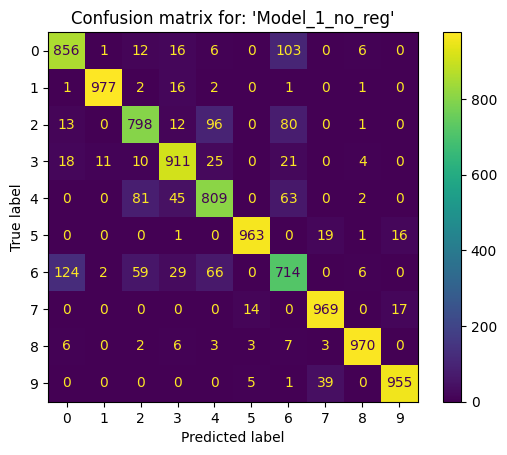

['0 - T-shirt/top', '1 - Trouser', '2 - Pullover', '3 - Dress', '4 - Coat', '5 - Sandal', '6 - Shirt', '7 - Sneaker', '8 - Bag', '9 - Ankle boot']
------------------------------------------------------------ 

Classification report for: 'Model_1_L2_0.1'
                 precision    recall  f1-score   support

0 - T-shirt/top       0.81      0.84      0.82      1000
1 - Trouser           0.99      0.96      0.98      1000
2 - Pullover          0.75      0.83      0.79      1000
3 - Dress             0.84      0.90      0.87      1000
4 - Coat              0.78      0.81      0.79      1000
5 - Sandal            0.97      0.95      0.96      1000
6 - Shirt             0.76      0.60      0.67      1000
7 - Sneaker           0.92      0.97      0.94      1000
8 - Bag               0.97      0.97      0.97      1000
9 - Ankle boot        0.97      0.94      0.95      1000

       accuracy                           0.88     10000
      macro avg       0.88      0.88      0.87     10000
   

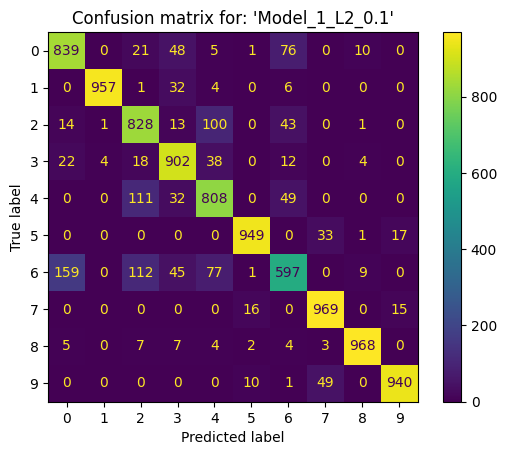

['0 - T-shirt/top', '1 - Trouser', '2 - Pullover', '3 - Dress', '4 - Coat', '5 - Sandal', '6 - Shirt', '7 - Sneaker', '8 - Bag', '9 - Ankle boot']
------------------------------------------------------------ 

Classification report for: 'Model_2'
                 precision    recall  f1-score   support

0 - T-shirt/top       0.84      0.86      0.85      1000
1 - Trouser           0.99      0.97      0.98      1000
2 - Pullover          0.81      0.83      0.82      1000
3 - Dress             0.89      0.91      0.90      1000
4 - Coat              0.79      0.86      0.82      1000
5 - Sandal            0.97      0.97      0.97      1000
6 - Shirt             0.76      0.66      0.70      1000
7 - Sneaker           0.95      0.96      0.95      1000
8 - Bag               0.98      0.98      0.98      1000
9 - Ankle boot        0.96      0.96      0.96      1000

       accuracy                           0.89     10000
      macro avg       0.89      0.89      0.89     10000
   weighte

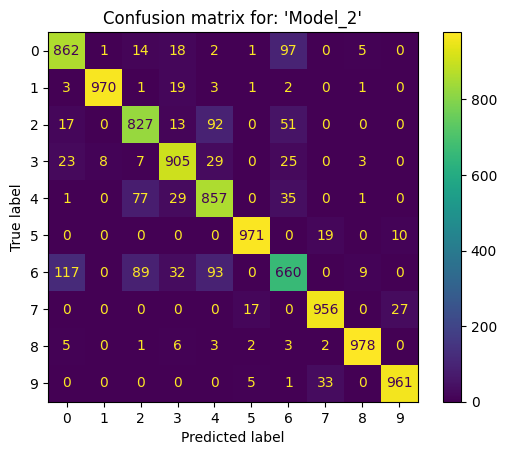

['0 - T-shirt/top', '1 - Trouser', '2 - Pullover', '3 - Dress', '4 - Coat', '5 - Sandal', '6 - Shirt', '7 - Sneaker', '8 - Bag', '9 - Ankle boot']
------------------------------------------------------------ 

Classification report for: 'Model_2_L2_0.1'
                 precision    recall  f1-score   support

0 - T-shirt/top       0.83      0.84      0.83      1000
1 - Trouser           0.99      0.97      0.98      1000
2 - Pullover          0.78      0.82      0.80      1000
3 - Dress             0.88      0.89      0.89      1000
4 - Coat              0.81      0.78      0.79      1000
5 - Sandal            0.96      0.96      0.96      1000
6 - Shirt             0.68      0.70      0.69      1000
7 - Sneaker           0.95      0.94      0.95      1000
8 - Bag               0.99      0.96      0.97      1000
9 - Ankle boot        0.95      0.96      0.96      1000

       accuracy                           0.88     10000
      macro avg       0.88      0.88      0.88     10000
   

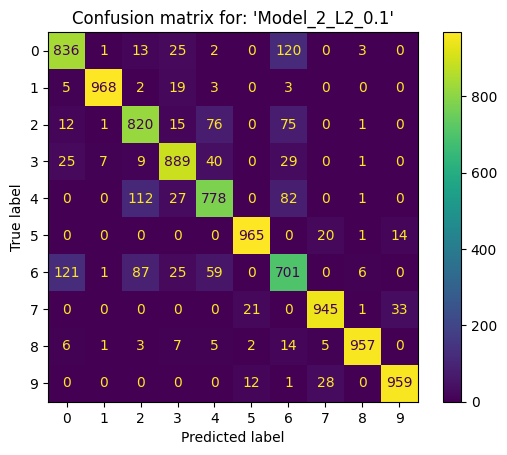

['0 - T-shirt/top', '1 - Trouser', '2 - Pullover', '3 - Dress', '4 - Coat', '5 - Sandal', '6 - Shirt', '7 - Sneaker', '8 - Bag', '9 - Ankle boot']
------------------------------------------------------------ 

Classification report for: 'Model_2_L2_1'
                 precision    recall  f1-score   support

0 - T-shirt/top       0.81      0.80      0.81      1000
1 - Trouser           0.99      0.95      0.97      1000
2 - Pullover          0.81      0.75      0.78      1000
3 - Dress             0.87      0.85      0.86      1000
4 - Coat              0.75      0.82      0.79      1000
5 - Sandal            0.97      0.91      0.94      1000
6 - Shirt             0.65      0.68      0.66      1000
7 - Sneaker           0.88      0.97      0.92      1000
8 - Bag               0.96      0.97      0.97      1000
9 - Ankle boot        0.96      0.93      0.94      1000

       accuracy                           0.86     10000
      macro avg       0.87      0.86      0.86     10000
   we

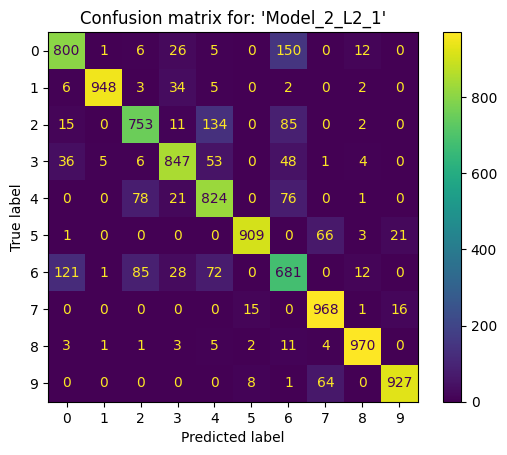

['0 - T-shirt/top', '1 - Trouser', '2 - Pullover', '3 - Dress', '4 - Coat', '5 - Sandal', '6 - Shirt', '7 - Sneaker', '8 - Bag', '9 - Ankle boot']
------------------------------------------------------------ 

Classification report for: 'Model_3_DO_0.2'
                 precision    recall  f1-score   support

0 - T-shirt/top       0.84      0.87      0.86      1000
1 - Trouser           0.99      0.98      0.98      1000
2 - Pullover          0.82      0.80      0.81      1000
3 - Dress             0.89      0.92      0.90      1000
4 - Coat              0.79      0.82      0.80      1000
5 - Sandal            0.99      0.97      0.98      1000
6 - Shirt             0.75      0.69      0.72      1000
7 - Sneaker           0.95      0.97      0.96      1000
8 - Bag               0.98      0.98      0.98      1000
9 - Ankle boot        0.97      0.96      0.96      1000

       accuracy                           0.90     10000
      macro avg       0.90      0.90      0.90     10000
   

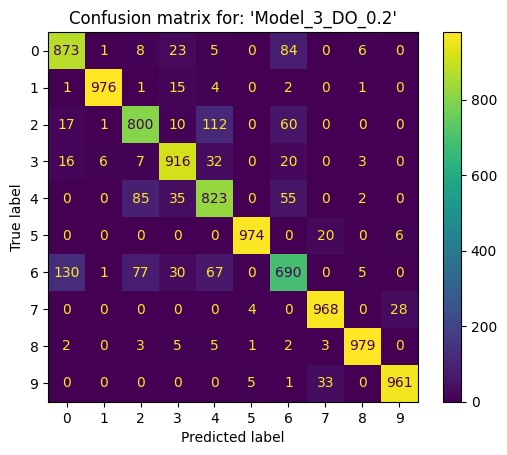

['0 - T-shirt/top', '1 - Trouser', '2 - Pullover', '3 - Dress', '4 - Coat', '5 - Sandal', '6 - Shirt', '7 - Sneaker', '8 - Bag', '9 - Ankle boot']
------------------------------------------------------------ 

Classification report for: 'Model_3_DO_0.5'
                 precision    recall  f1-score   support

0 - T-shirt/top       0.75      0.86      0.81      1000
1 - Trouser           1.00      0.95      0.97      1000
2 - Pullover          0.74      0.75      0.74      1000
3 - Dress             0.85      0.89      0.87      1000
4 - Coat              0.71      0.81      0.76      1000
5 - Sandal            0.97      0.94      0.95      1000
6 - Shirt             0.70      0.48      0.57      1000
7 - Sneaker           0.90      0.96      0.93      1000
8 - Bag               0.97      0.97      0.97      1000
9 - Ankle boot        0.96      0.93      0.95      1000

       accuracy                           0.85     10000
      macro avg       0.86      0.85      0.85     10000
   

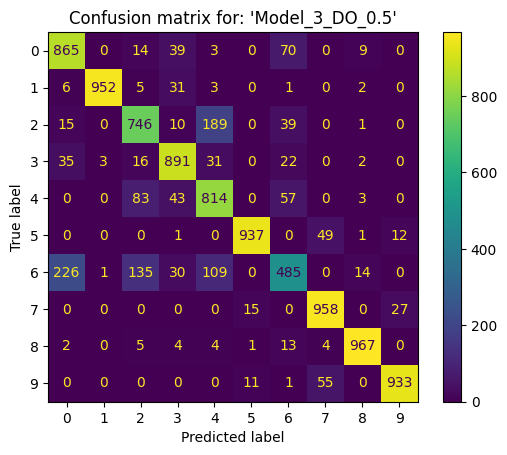

['0 - T-shirt/top', '1 - Trouser', '2 - Pullover', '3 - Dress', '4 - Coat', '5 - Sandal', '6 - Shirt', '7 - Sneaker', '8 - Bag', '9 - Ankle boot']
------------------------------------------------------------ 

Classification report for: 'Model_2_lrelu'
                 precision    recall  f1-score   support

0 - T-shirt/top       0.83      0.86      0.85      1000
1 - Trouser           0.99      0.97      0.98      1000
2 - Pullover          0.80      0.81      0.80      1000
3 - Dress             0.85      0.92      0.88      1000
4 - Coat              0.81      0.81      0.81      1000
5 - Sandal            0.97      0.97      0.97      1000
6 - Shirt             0.76      0.68      0.72      1000
7 - Sneaker           0.94      0.96      0.95      1000
8 - Bag               0.97      0.97      0.97      1000
9 - Ankle boot        0.96      0.95      0.96      1000

       accuracy                           0.89     10000
      macro avg       0.89      0.89      0.89     10000
   w

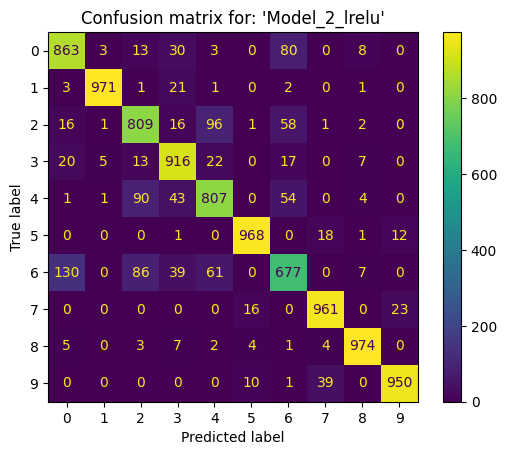

['0 - T-shirt/top', '1 - Trouser', '2 - Pullover', '3 - Dress', '4 - Coat', '5 - Sandal', '6 - Shirt', '7 - Sneaker', '8 - Bag', '9 - Ankle boot']
------------------------------------------------------------ 

Classification report for: 'Model_2_lrelu_b32'
                 precision    recall  f1-score   support

0 - T-shirt/top       0.86      0.79      0.82      1000
1 - Trouser           0.99      0.97      0.98      1000
2 - Pullover          0.82      0.76      0.79      1000
3 - Dress             0.88      0.90      0.89      1000
4 - Coat              0.76      0.84      0.80      1000
5 - Sandal            0.95      0.97      0.96      1000
6 - Shirt             0.67      0.72      0.69      1000
7 - Sneaker           0.95      0.94      0.94      1000
8 - Bag               0.98      0.95      0.97      1000
9 - Ankle boot        0.97      0.95      0.96      1000

       accuracy                           0.88     10000
      macro avg       0.88      0.88      0.88     10000


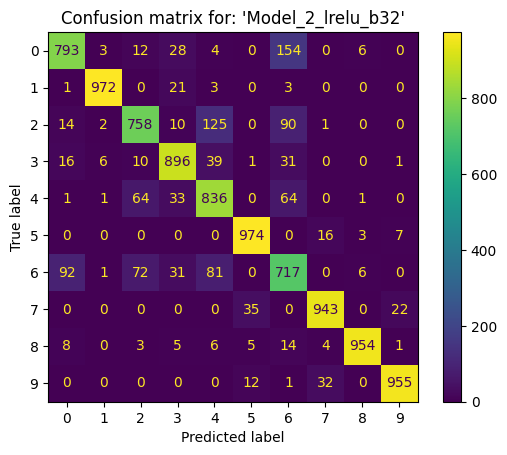

['0 - T-shirt/top', '1 - Trouser', '2 - Pullover', '3 - Dress', '4 - Coat', '5 - Sandal', '6 - Shirt', '7 - Sneaker', '8 - Bag', '9 - Ankle boot']
------------------------------------------------------------ 

Classification report for: 'Model_2_lrelu_sgd'
                 precision    recall  f1-score   support

0 - T-shirt/top       0.82      0.82      0.82      1000
1 - Trouser           0.98      0.96      0.97      1000
2 - Pullover          0.77      0.74      0.75      1000
3 - Dress             0.85      0.88      0.87      1000
4 - Coat              0.75      0.79      0.77      1000
5 - Sandal            0.95      0.94      0.95      1000
6 - Shirt             0.66      0.62      0.64      1000
7 - Sneaker           0.91      0.94      0.93      1000
8 - Bag               0.94      0.95      0.95      1000
9 - Ankle boot        0.95      0.94      0.95      1000

       accuracy                           0.86     10000
      macro avg       0.86      0.86      0.86     10000


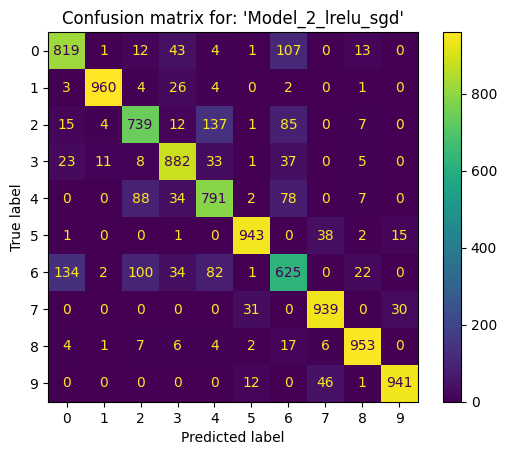

['0 - T-shirt/top', '1 - Trouser', '2 - Pullover', '3 - Dress', '4 - Coat', '5 - Sandal', '6 - Shirt', '7 - Sneaker', '8 - Bag', '9 - Ankle boot']
------------------------------------------------------------ 

Classification report for: 'Model_2_lrelu_bnorm'
                 precision    recall  f1-score   support

0 - T-shirt/top       0.83      0.86      0.84      1000
1 - Trouser           0.98      0.98      0.98      1000
2 - Pullover          0.79      0.83      0.81      1000
3 - Dress             0.87      0.90      0.89      1000
4 - Coat              0.80      0.84      0.82      1000
5 - Sandal            0.97      0.96      0.97      1000
6 - Shirt             0.76      0.64      0.70      1000
7 - Sneaker           0.95      0.95      0.95      1000
8 - Bag               0.98      0.97      0.97      1000
9 - Ankle boot        0.95      0.96      0.95      1000

       accuracy                           0.89     10000
      macro avg       0.89      0.89      0.89     1000

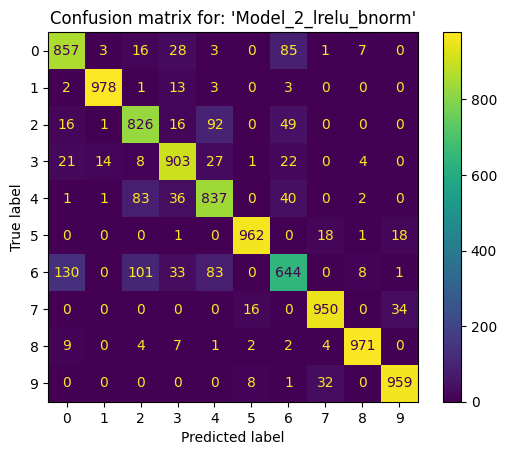

['0 - T-shirt/top', '1 - Trouser', '2 - Pullover', '3 - Dress', '4 - Coat', '5 - Sandal', '6 - Shirt', '7 - Sneaker', '8 - Bag', '9 - Ankle boot']
------------------------------------------------------------ 



In [104]:
target_names = [ f"{i} - {labels[i]:11}" for i in range(0, num_classes)]

for name in models_his.keys():
  print(f"Classification report for: '{name}'")
  print(classification_report(y_test, test_pred_values[name], target_names=target_names))
  cr = classification_report(y_test, test_pred_values[name], target_names=target_names, output_dict=True)
  roc_auc = roc_auc_score(y_test, test_pred[name], multi_class='ovo')
  print(f'Accuracy: {cr["accuracy"]:.2%}, ROC-AUC: {roc_auc:.4f}')
  print(f"\nConfusion matrix for: '{name}'")
  confusion_matrix(y_test, test_pred_values[name])
  ConfusionMatrixDisplay.from_predictions(y_test, test_pred_values[name])
  plt.title(f"Confusion matrix for: '{name}'")
  plt.show()
  print(list(map(lambda x: x.strip(),target_names)))
  print("-"*60,"\n")

## Порівняння моделей за val. accur.

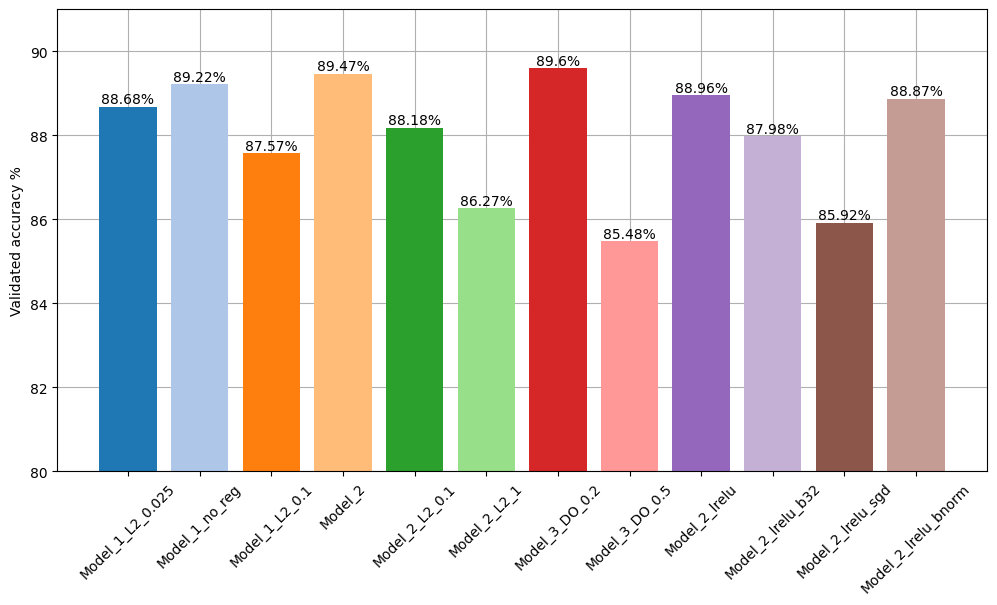

In [105]:
bar_y = [ results[m][1]*100 for m in models ]

plt.figure(figsize=(12,6))
plt.grid()
plt.gca().set_axisbelow(True)
colors = range(len(models))  # Choose the index of the color from the colormap
bars = plt.bar(x=models.keys(), height=bar_y, color=plt.cm.tab20(colors))
for bar, value in zip(bars, bar_y):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{value:.4}%", ha='center', va='bottom')

plt.ylim(80,91)
plt.xticks(rotation=45)
plt.ylabel("Validated accuracy %")
plt.show()

## Візуалізація прогнозу

Model_2


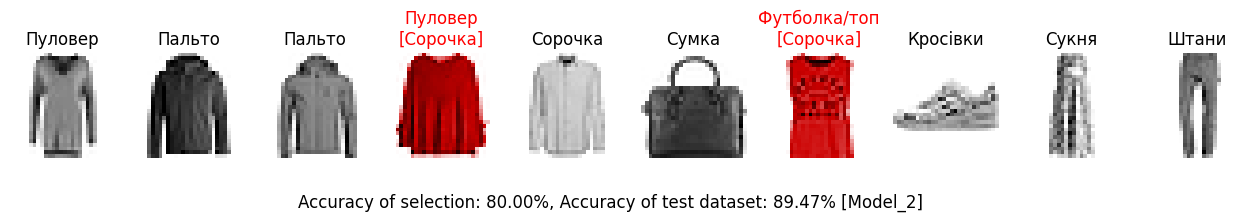

In [113]:
img_selected = 10
np.random.seed(43)
random_img_idx = np.random.randint(0, x_test.shape[0], size=img_selected)
#selected_model_name = list(models.keys())[0]
selected_model_name = "Model_2"
print(selected_model_name)
# Plot the images
colors = [(1, 1, 1), (0.8, 0, 0), (0, 0, 0)]  # white, red, black
custom_cmap = plt.cm.colors.LinearSegmentedColormap.from_list("CustomRed", colors, N=256)

plt.figure(figsize=(16, 5))
pred = 0
for i, idx in enumerate(random_img_idx, start=1):
    plt.subplot(1, img_selected, i)
    y_pred = test_pred_values[selected_model_name]

    correct = y_test[idx] == y_pred[idx]
    pred += int(correct)
    cmap = 'gray_r' if correct else custom_cmap
    color = "black" if correct else "red"
    plt.imshow(x_test[idx], cmap=cmap)
    title = labels_uk[y_test[idx]] if correct else f'{labels_uk[y_test[idx]]}\n[{labels_uk[test_pred_values[selected_model_name][idx]]}]'
    plt.title(title, color=color)
    plt.axis('off')

acc = pred/img_selected
plt.suptitle(f"Accuracy of selection: {acc:.2%}, Accuracy of test dataset: {results[selected_model_name][1]:.2%} [{selected_model_name}]")
plt.subplots_adjust(top=2.2)
plt.show()

## Висновок

Використано ряд моделей нейронних мереж для заданого набору даних "Fashion-MNIST".

Для порівняння та вибору найкращої моделі були побудовані декілька моделей з різною кількістю шарів, та різними значеннями гіперпараметрів.

Для забезпечення зупинення перенавчання моделі (overfit) застосовано додавання регуляризатора в одному з шарів типу L2, з різними значеннями. Також протестовано моделі на різних активаційних функціях таких як "relu", та "leaky_relu".

Використано оптимізаційні алгоритми "Adam" та "SGD" для пошуку вагів моделі.

Крок навчання використано динамічний залежно від епохи. Залежність може бути двоступенева - до 7 епохи 0.005, далі крок навчання дорівнює 0.001, та експоненціальна.

Для автоматичного зупинення пошуку нових ваг для моделі було застосовано "Early stop" як по метриці "val_loss" (min) patience=5, так і по метриці "val_accuracy" (max) patience=10.

Побудовані графіки залежностей для кожної з моделей, з відображенням найкращої епохи для вагів, котрі були вибранні. Де можна побачити тенденцію моделі до перенавчання.

Завдяки застосуванню "Early stop" загальні характеристики моделей у на діаграмі "Validated accuracy" певним чином вирівнялися, і перенавчання своєчасно було зупинено.

Вибір найкращої моделі базується на її простоті, швидкості та якості за мінімальними значеннями втрат "val_loss", та максимальним значенням якості "val_accuracy".

За вибраною моделлю "Model_2" побудовані випадкові передбачення для 10 зображень з тестової вибірки набору даних та результати побачення де червоний колір означає передбачення було помилкове.

За значеннями результатів confusion matrix бачимо що найгірша ситуація з прогнозуванням категорії 6 - 'Shirt' [Сорочка] яка має найбільшу кількість помилок з категорією 0 'T-shirt/top' [Футболка/Топ] та '4 - Coat' [Пальто], що і показала тестова вибірка.

Моделі та історії розрахунків зберігаються до [архівного файлу](https://drive.google.com/file/d/10IrPreMKLTAT7BKhK693X0X1JnvygJnQ/view?usp=drive_link), і завантажуються з нього для пришвидшення отримання вже розрахованих результатів.